# General LASSO

$$L(\vec{x})=\frac{1}{2}(y_{i}-A^{*}_{ij}x_{j})(y_{i}-A_{ik}x_{k})+\frac{\lambda_2}{2}[(D^{1}_{ij} x_{j})(D^{1}_{ik}x_{k})+ (D^{2}_{ij} x_{j})(D^{2}_{ik}x_{k})]+ \lambda_1 \sigma_i |x_i|,$$

where $x_i$ is the i-th component of real vector $\vec{x}$, $A_{ij}$ and $D^{1,2}_{ij}$ are the $(i,j)$ component of matrix $\mathbf{A}$ and $\mathbf{D^{1,2}}$. $A_{ij}$ is complex number whereas $D^{1,2}_{ij}$ are real number. $A^{*}_{ij}$ is used to denote the conjugate of $A_{ij}$.

$\mathbf{A}$ refers to the transformation operator from the real dictionary field to the observed complex shear field. Note that we do not consider $B$ mode so $x$ is a real vector. 

```python
# sparseBase.massmapSparsityTask.__init__
## Initialization of the Dictionary Space (A)
# 1) Basis vector used to model the Surface Density of halo  
if dicname=='starlet':
    from halolet import starlet2D
    self.dict2D =   starlet2D(gen=2,nframe=self.nframe,ny=self.ny,nx=self.nx)
elif dicname=='nfwlet':
    from halolet import nfwlet2D
    self.dict2D =   nfwlet2D(nframe=self.nframe,ngrid=self.nx,smooth_scale=-1)
# 2) From Surface Density of Excess Surface Density
self.ks2D   =   massmap_ks2D(self.ny,self.nx)

# 3) Lening Kernel: from Excess Surface Density to Shear

if self.nlp<=1:
    self.lensKernel =   np.ones((self.nz,self.nlp))
else:
    self.lensKernel =   np.zeros((self.nz,self.nlp))
    for i,zs in enumerate(zsbin):
        self.lensKernel[i,:]    =   self.cosmo.deltacritinv(zlbin,zs)
```

$\mathbf{D^{1,2}}$ refer to difference operators in two transverse  (ra, dec) directions. $\lambda_2$ control the amplitude of the Total Square Variance (TSV) term.


```python
# sparseBase.massmapSparsityTask.gradient_TSV
# Definition of D1 and D2
difx    =   np.roll(self.alphaR[:,0,:,:],1,axis=-1)
difx    =   difx-self.alphaR[:,0,:,:] # D1
dify    =   np.roll(self.alphaR[:,0,:,:],1,axis=-2)
dify    =   dify-self.alphaR[:,0,:,:] # D2
```

We separate out the second order terms in the loss function.
$$F(\vec{x})=\frac{1}{2}(y_{i}-A^{*}_{ij}x_{j})(y_{i}-A_{ik}x_{k})+\frac{\lambda_2}{2}[(D^{1}_{ij} x_{j})(D^{1}_{ik}x_{k})+ (D^{2}_{ij} x_{j})(D^{2}_{ik}x_{k})],$$

Then we approach to the minimum of the loss function ($L(\vec{x})$) by iteratively updates each component of $\vec{x}$
$$x_{\alpha}^{(n+1)}=x_{\alpha}^{(n)}-S_{\lambda_1 \sigma_{\alpha}}(\frac{\mu\partial_{\alpha}F(\vec{x})}{A_{i\alpha}A_{i\alpha}+4\lambda_2}),$$

where

$$\partial_\alpha F(\vec{x})=-A_{i\alpha}^{*} (y_{i}-A_{ij}x_{j}) + \lambda_2(D^1_{i\alpha}D^1_{ij} x_{j}+ D^2_{i\alpha} D^2_{ij} x_j).$$

$\mu$ is the step size of the iteration. S_{\lambda} is the soft thresholding function defined as:

$$S_{\lambda} (x_{\alpha})=\rm{sign}(x_{\alpha}) \rm{max}(|x_{\alpha}| - \lambda,0)$$


```python

# sparseBase.massmapSparsityTask.gradient
# calculate the gradient of the Second order component in loss function 
# wihch includes Total Square Variance(TSV) and chi2 components
gCh2=self.gradient_chi2()
gTSV=self.gradient_TSV()

# sparseBase.massmapSparsityTask.gradient_chi2
# calculate the gradient of the chi2 component
shearRTmp   =   self.main_forward(self.alphaR) #A_{ij} x_j
self.shearRRes   =   self.shearR-shearRTmp     #y_i-A_{ij} x_j
dalphaR     =   -self.main_transpose(self.shearRRes)/2. #-A_{i\alpha}(y_i-A_{ij} x_j)/2

# sparseBase.massmapSparsityTask.gradient_TSV
gradx   =   np.roll(difx,-1,axis=-1)
gradx   =   gradx-difx    # (D1)_{i\alpha} (D1)_{ij} x_j
grady   =   np.roll(dify,-1,axis=-2)  
grady   =   grady-dify    # (D2)_{i\alpha} (D2)_{ij} x_j
dalphaR[:,0,:,:]=(gradx+grady)*self.lbd2/2.
```

Note that here $A_{i\alpha} A_{i\alpha}$ should be estimated taking into account the mask of observed shear field.
```python
# sparseBase.massmapSparsityTask.spectrum_norm
# Estimate A_{i\alpha} A_{i\alpha}
asquareframe=np.zeros((self.nz,self.nframe,self.ny,self.nx))
for iz in range(self.nz):
    maskF=np.fft.fft2(self.mask[iz,:,:])
    for iframe in range(self.nframe):
        fun=np.abs(self.ks2D.transform(self.dict2D.fouaframes[iframe,:,:],outFou=False))**2.
        asquareframe[iz,iframe,:,:]=np.fft.ifft2(np.fft.fft2(fun).real*maskF).real

spectrum=np.sum(self.lensKernel[:,:,None,None,None]*asquareframe[:,None,:,:,:],axis=0)
self.mu=0.1/(spectrum+4.*self.lbd2) #we chose mu=0.1
```

In [84]:
%pylab inline
import os
import cosmology
import numpy as np
import astropy.io.fits as pyfits

try:
    # use lsst.afw.display and firefly backend for display
    import lsst.log as logging
    import lsst.afw.image as afwImage
    import lsst.afw.display as afwDisplay
    afwDisplay.setDefaultBackend('firefly')
    haslsst=True
except ImportError:
    haslsst=False
from configparser import ConfigParser
    

def zMeanBin(zMin,dz,nz):
    return np.arange(zMin,zMin+dz*nz,dz)+dz/2.


# LASSO Threshold Functions
def soft_thresholding(dum,thresholds):
    # Standard Threshold Function
    return np.sign(dum)*np.maximum(np.abs(dum)-thresholds,0.)

def firm_thresholding(dum,thresholds):
    # I do not understand
    mask    =   (np.abs(dum)<= thresholds)
    dum[mask]=  0.
    mask    =   (np.abs(dum)>thresholds)
    mask    =   mask&(np.abs(dum)<= 2*thresholds)
    dum[mask]=  np.sign(dum[mask])*(2*np.abs(dum[mask])-thresholds[mask])
    return dum

def my_thresholding(dum,thresholds):
    # doesnot work @_@
    mask    =   (abs(dum)<= thresholds)
    dum[mask]=  0.
    mask    =   (abs(dum)>thresholds)
    dum[mask]=  np.sign(dum[mask])*(abs(dum[mask])-thresholds[mask]**2./abs(dum[mask]))
    return dum

class massmap_ks2D():
    def __init__(self,ny,nx):
        self.shape   =   (ny,nx)
        self.e2phiF  =   self.e2phiFou(self.shape)

    def e2phiFou(self,shape):
        ny1,nx1 =   shape
        e2phiF  =   np.zeros(shape,dtype=complex)
        for j in range(ny1):
            jy  =   (j+ny1//2)%ny1-ny1//2
            jy  =   jy/ny1
            for i in range(nx1):
                ix  =   (i+nx1//2)%nx1-nx1//2
                ix  =   ix/nx1
                if (i**2+j**2)>0:
                    e2phiF[j,i]    =   np.complex((ix**2.-jy**2.),2.*ix*jy)/(ix**2.+jy**2.)
                else:
                    e2phiF[j,i]    =   1.
        return e2phiF*np.pi

    def itransform(self,gMap,inFou=True,outFou=True):
        assert gMap.shape==self.shape
        if not inFou:
            gMap =   np.fft.fft2(gMap)
        kOMap    =   gMap/self.e2phiF*np.pi
        if not outFou:
            kOMap    =   np.fft.ifft2(kOMap)
        return kOMap

    def transform(self,kMap,inFou=True,outFou=True):
        assert kMap.shape==self.shape
        if not inFou:
            kMap =   np.fft.fft2(kMap)
        gOMap    =   kMap*self.e2phiF/np.pi
        if not outFou:
            gOMap    =   np.fft.ifft2(gOMap)
        return gOMap

class massmapSparsityTask():
    def __init__(self,sources,parser):
        #display
        self.display_irun=30
        self.display_izl=0
        self.display_iframe=0
        #file
        assert parser.has_option('file','pixDir'), 'Do not have pixDir'
        self.pixDir   =   parser.get('file','pixDir')
        assert parser.has_option('file','frameDir'), 'Do not have frameDir'
        self.frameDir =   parser.get('file','frameDir')
        assert parser.has_option('file','lbdDir'), 'Do not have lbdDir'
        self.lbdDir   =   parser.get('file','lbdDir')
        if parser.has_option('file','fieldN'):
            self.fieldN =   parser.get('file','fieldN')
        else:
            self.fieldN  =   'test'

        #sparse
        self.lbd    =   parser.getfloat('sparse','lbd')
        if parser.has_option('sparse','lbd2'):
            self.lbd2   =   parser.getfloat('sparse','lbd2')
        else:
            self.lbd2   =   0.
        self.nframe =   parser.getint('sparse','nframe')
        self.nMax   =   parser.getint('sparse','nMax')
        self.maxR   =   parser.getint('sparse','maxR')
        outFname    =   'deltaMap_lbd%.1f_%s.fits' %(self.lbd,self.fieldN)
        self.outFname   =   os.path.join(self.lbdDir,outFname)

        #transverse plane
        if parser.has_option('transPlane','raname'):
            self.raname     =   parser.get('transPlane','raname')
        else:
            self.raname     =   'ra'
        if parser.has_option('transPlane','decname'):
            self.decname    =   parser.get('transPlane','decname')
        else:
            self.decname    =   'dec'
        self.xMin   =   parser.getfloat('transPlane','xMin')
        self.yMin   =   parser.getfloat('transPlane','yMin')
        self.scale  =   parser.getfloat('transPlane','scale')
        self.ny     =   parser.getint('transPlane'  ,'ny')
        self.nx     =   parser.getint('transPlane'  ,'nx')

        #lens z axis
        self.nlp    =   parser.getint('lensZ','nlp')
        if self.nlp<=1:
            self.zlMin  =   0.
            self.zlscale=   1.
        else:
            self.zlMin       =   parser.getfloat('lensZ','zlMin')
            self.zlscale     =   parser.getfloat('lensZ','zlscale')
        zlBin       =   zMeanBin(self.zlMin,self.zlscale,self.nlp)

        #source z axis
        if parser.has_option('sourceZ','zname'):
            self.zname      =   parser.get('sourceZ','zname')
        else:
            self.zname      =   'z'

        self.nz     =   parser.getint('sourceZ','nz')
        if self.nz<=1:
            self.zMin   =   0.01
            self.zscale =   2.5
        else:
            self.zMin   =   parser.getfloat('sourceZ','zMin')
            self.zscale =   parser.getfloat('sourceZ','zscale')
        zsBin       =   zMeanBin(self.zMin,self.zscale,self.nz)

        self.shapeS =   (self.nz,self.ny,self.nx)
        self.shapeL =   (self.nlp,self.ny,self.nx)
        self.shapeA =   (self.nlp,self.nframe,self.ny,self.nx)

        self.cosmo  =   cosmology.Cosmo(h=1)
        lensKName   =   os.path.join(self.pixDir,'lensKernel.fits')
        if os.path.exists(lensKName):
            self.lensKernel =   pyfits.getdata(lensKName)
            assert self.lensKernel.shape==   (self.nz,self.nlp), 'load wrong lensing kernel'
        else:
            self.lensing_kernel(zlBin,zsBin)
            pyfits.writeto(lensKName,self.lensKernel)

        dicname =   parser.get('sparse','dicname')
        if dicname=='starlet':
            from halolet import starlet2D
            self.dict2D =   starlet2D(gen=2,nframe=self.nframe,ny=self.ny,nx=self.nx)
        elif dicname=='nfwlet':
            from halolet import nfwlet2D
            self.dict2D =   nfwlet2D(nframe=self.nframe,ngrid=self.nx,smooth_scale=-1)
        self.ks2D   =   massmap_ks2D(self.ny,self.nx)

        # Read pixelized shear and mask
        g1Fname     =   os.path.join(self.pixDir,'g1Map_%s.fits'%self.fieldN)
        g2Fname     =   os.path.join(self.pixDir,'g2Map_%s.fits'%self.fieldN)
        nFname      =   os.path.join(self.pixDir,'nMap_%s.fits'%self.fieldN)
        assert os.path.exists(nFname),'cannot find pixelized shear, run binSplit first'
        self.nMap   =   pyfits.getdata(nFname)
        g1Map       =   pyfits.getdata(g1Fname)
        g2Map       =   pyfits.getdata(g2Fname)
        assert self.nMap.shape  ==   self.shapeS, 'load wrong pixelized shear'
        self.mask   =   (self.nMap>=0.1)

        # Estimate mu
        self.spectrum_norm()

        # Estimate variance plane for alpha
        sigma_noise =   parser.getfloat('sparse','sigma_noise')
        self.prox_sigmaA(100,sigma_noise)
        
        # Initialization
        self.alphaR =   np.zeros(self.shapeA)   # alpha
        self.deltaR =   np.zeros(self.shapeL)   # delta
        self.shearRRes   = np.zeros(self.shapeS)# shear residuals
        self.shearR =   g1Map+np.complex128(1j)*g2Map # shear
        return

    def lensing_kernel(self,zlbin,zsbin):
        logging.info('Calculating lensing kernel')
        if self.nlp<=1:
            self.lensKernel =   np.ones((self.nz,self.nlp))
        else:
            self.lensKernel =   np.zeros((self.nz,self.nlp))
            for i,zs in enumerate(zsbin):
                self.lensKernel[i,:]    =   self.cosmo.deltacritinv(zlbin,zs)
        return

    def main_forward(self,alphaRIn):
        shearOut    =   np.zeros(self.shapeS,dtype=np.complex128)
        for zl in range(self.nlp):
            deltaFZl=   self.dict2D.itransform(alphaRIn[zl,:,:,:],inFou=False)
            shearRZl=   self.ks2D.transform(deltaFZl,outFou=False)
            shearOut+=  (self.lensKernel[:,zl,None,None]*shearRZl)
        shearOut    =   shearOut*(self.mask.astype(np.int))
        return shearOut

    def main_transpose(self,shearRIn):
        deltaFTmp       =   np.zeros(self.shapeL,dtype=np.complex128)
        for zs in range(self.nz):
            kappaFZs    =   self.ks2D.itransform(shearRIn[zs],inFou=False)
            deltaFTmp  +=   (self.lensKernel[zs,:,None,None]*kappaFZs)
        alphaRO         =   np.empty(self.shapeA)
        for zl in range(self.nlp):
            alphaRO[zl,:,:,:]=self.dict2D.itranspose(deltaFTmp[zl],outFou=False).real
        return alphaRO

    def gradient_chi2(self):
        # sparseBase.massmapSparsityTask.gradient_chi2
        # calculate the gradient of the chi2 component
        shearRTmp   =   self.main_forward(self.alphaR) #A_{ij} x_j
        self.shearRRes   =   self.shearR-shearRTmp     #y_i-A_{ij} x_j
        dalphaR     =   -self.main_transpose(self.shearRRes)/2. #-A_{i\alpha}(y-A_{ij} x_j)/2
        return dalphaR

    def gradient_TSV(self):
        # sparseBase.massmapSparsityTask.gradient_TSV
        # calculate the gradient of the Total Square Variance(TSV) component
        
        # Initialization
        dalphaR =   np.zeros(self.shapeA)
        
        difx    =   np.roll(self.alphaR[:,0,:,:],1,axis=-1)
        difx    =   difx-self.alphaR[:,0,:,:] #D1
        gradx   =   np.roll(difx,-1,axis=-1)
        gradx   =   gradx-difx # (D1)_{i\alpha} (D1)_{ij} x_j

        dify    =   np.roll(self.alphaR[:,0,:,:],1,axis=-2)
        dify    =   dify-self.alphaR[:,0,:,:] #D2
        grady   =   np.roll(dify,-1,axis=-2)
        grady   =   grady-dify # (D2)_{i\alpha} (D2)_{ij} x_j
        dalphaR[:,0,:,:]=(gradx+grady)*self.lbd2/2.
        return dalphaR

    def gradient(self):
        # sparseBase.massmapSparsityTask.gradient
        # calculate the gradient of the Second order component in loss function 
        # wihch includes Total Square Variance(TSV) and chi2 components
        gCh2=self.gradient_chi2()
        gTSV=self.gradient_TSV()
        return gCh2+gTSV

    def spectrum_norm(self):
        # sparseBase.massmapSparsityTask.spectrum_norm
        # Estimate A_{i\alpha} A_{i\alpha}
        asquareframe=np.zeros((self.nz,self.nframe,self.ny,self.nx))
        for iz in range(self.nz):
            maskF=np.fft.fft2(self.mask[iz,:,:])
            for iframe in range(self.nframe):
                fun=np.abs(self.ks2D.transform(self.dict2D.fouaframes[iframe,:,:],outFou=False))**2.
                asquareframe[iz,iframe,:,:]=np.fft.ifft2(np.fft.fft2(fun).real*maskF).real

        spectrum=np.sum(self.lensKernel[:,:,None,None,None]*asquareframe[:,None,:,:,:],axis=0)
        spectrum[:,0,:,:]=spectrum[:,0,:,:]+4.*self.lbd2 
        self.mu=0.1/spectrum#we chose mu=0.8
        return

    def prox_sigmaA(self,niter,sigma):
        logging.info('Estimating sigma map')
        outData     =   np.zeros(self.shapeA)
        if sigma<=0:
            logging.info('using mock catalog to calculate alpha sigma')
            simSrcName  =   os.path.join(self.pixDir,'mock_RG_grid_%s.npy' %(self.fieldN))
            simSrc      =   np.load(simSrcName)
            for irun in range(niter):
                shearSim    =   simSrc[irun]
                alphaRSim   =   self.main_transpose(shearSim)
                outData     +=  alphaRSim**2.
        else:
            sigMap  =   np.zeros(self.shapeS)
            sigMap[self.mask]  =   sigma/np.sqrt(self.nMap[self.mask])
            for irun in range(niter):
                np.random.seed(irun)
                g1Sim   =   np.random.randn(self.nz,self.ny,self.nx)*sigMap
                g2Sim   =   np.random.randn(self.nz,self.ny,self.nx)*sigMap
                shearSim=   g1Sim+np.complex128(1j)*g2Sim
                alphaRSim=  self.main_transpose(shearSim)
                outData +=  alphaRSim**2.
                
        maskL =   (np.sum(self.nMap,axis=0)>1.)
        for izlp in range(self.nlp):
            for iframe in range(self.nframe):
                outData[izlp,iframe][~maskL]=np.max(outData[izlp,iframe])
        self.sigmaA =   self.mu*np.sqrt(outData/niter)

        
        imgShow3=afwImage.ImageF(self.ny,self.nx)
        imgShow3.getArray()[:,:]=self.sigmaA[self.display_izl,self.display_iframe,:,:]
        display3 = afwDisplay.Display(frame=7)
        display3.mtv(imgShow3,title='sigma')
        imgShow3=afwImage.ImageF(self.ny,self.nx)
        imgShow3.getArray()[:,:]=outData[self.display_izl,self.display_iframe,:,:]
        display3 = afwDisplay.Display(frame=10)
        display3.mtv(imgShow3,title='outData')
        return

    def reconstruct(self):
        #update deltaR
        for zl in range(self.nlp):
            alphaRZ         =   self.alphaR[zl].copy()
            self.deltaR[zl] =   self.dict2D.itransform(alphaRZ,inFou=False,outFou=False)/self.zlscale
        return

    def run_main_iteration(self,iup,niter,threM='FT'):
        tn=0
        self.thresholds =   self.lbd*self.sigmaA
        for irun in range(niter):
            #save old kappaFou
            dalphaR =   -self.mu*self.gradient().real
            dum     =   self.alphaR.real+dalphaR
            if threM=='FT':
                dum  = firm_thresholding(dum,self.thresholds)
            elif threM=='ST':
                dum  = soft_thresholding(dum,self.thresholds)
            elif threM=='MT':
                dum  = my_thresholding(dum,self.thresholds)
            #update tn and get ratio
            tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
            ratio= (tn-1.)/tnTmp
            tn   = tnTmp
            self.alphaR=dum+(ratio*(dum-self.alphaR))
            # Display the fits file using lsst.afw.display and firefly backend
            if irun in range(self.display_irun-1, self.display_irun+1):
                begFrame=(1+irun-self.display_irun)*3
                imgShow=afwImage.ImageF(self.ny,self.nx)
                imgShow.getArray()[:,:]=self.alphaR.real[self.display_izl,self.display_iframe,:,:]
                display = afwDisplay.Display(frame=begFrame)
                display.mtv(imgShow,title='alpha-%s' %irun)
                imgShow=afwImage.ImageF(self.ny,self.nx)
                imgShow.getArray()[:,:]=dalphaR[self.display_izl,self.display_iframe,:,:]
                display = afwDisplay.Display(frame=begFrame+1)
                display.mtv(imgShow,title='dalpha-%s' %irun)
                self.reconstruct()
                imgShow=afwImage.ImageF(self.ny,self.nx)
                imgShow.getArray()[:,:]=self.deltaR[self.display_izl,:,:]
                display = afwDisplay.Display(frame=begFrame+2)
                display.mtv(imgShow,title='delta-%s' %irun)
        return

    def process(self,niter=51):
        self.thresholdsMin  =   self.lbd*self.sigmaA
        threM   =   'ST'
        self.run_main_iteration(0,niter,threM)
        self.reconstruct()
        return

    def write(self):
        pyfits.writeto(self.outFname,self.deltaR.real,overwrite=True)
        return

Populating the interactive namespace from numpy and matplotlib


/data1b/work/xiangchong.li/superonionMaster/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figure', 'logging']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
cd ./wrkDir/stampSim/oneHalo-2D/TSV-lbd1.5/

/lustre2/work/xiangchong.li/massMapSim/stampSim/oneHalo-2D/TSV-lbd1.5


# A simple Simulation

$M_{200}=4.41 \times 10^{14} M_{\odot}$

$z=0.38$

$\sigma_\gamma=0.25$

$40$ galaxies per arcmin

In [86]:
configName  =   'config_m9_z9.ini'
srcFname    =   'src_'+configName.split('.')[0]+'.fits'
parser      =   ConfigParser()
parser.read(configName)
sources     =   pyfits.getdata(srcFname)

# Pixel frame only

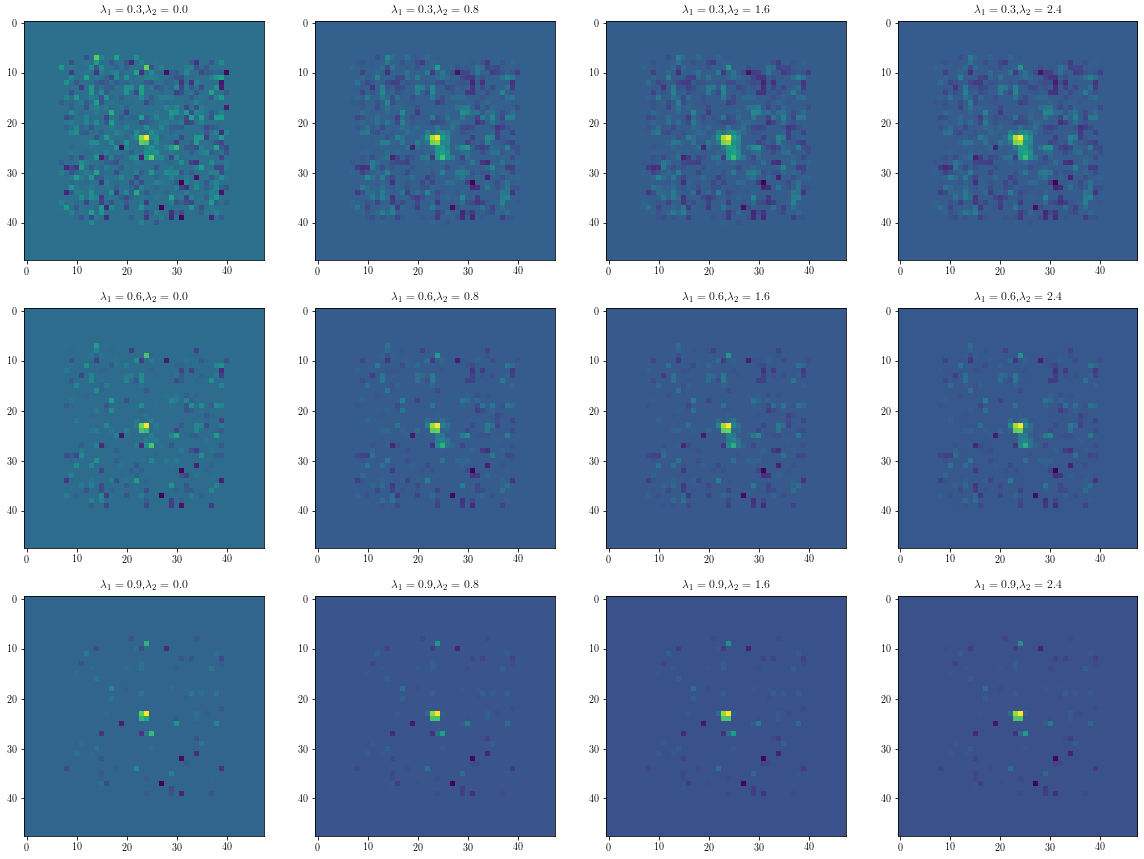

In [94]:
parser.set('sparse','nframe','1')
figure=plt.figure(figsize=(20,15))
for jplot in range(3):
    lbd1=(jplot+1)*0.3
    parser.set('sparse','lbd','%s' %lbd1)
    for iplot in range(4):
        ax=figure.add_subplot(3,4,jplot*4+iplot+1)
        lbd2=iplot*0.8
        parser.set('sparse','lbd2','%s' %lbd2)
        sparse3D    =   massmapSparsityTask(sources,parser)
        sparse3D.process()
        title=r'$\lambda_1=%.1f$,$\lambda_2=%.1f$' %(lbd1,lbd2)
        ax.imshow(sparse3D.deltaR[0,:,:])
        ax.set_title(title)

# Pixel frame + one halo frame 

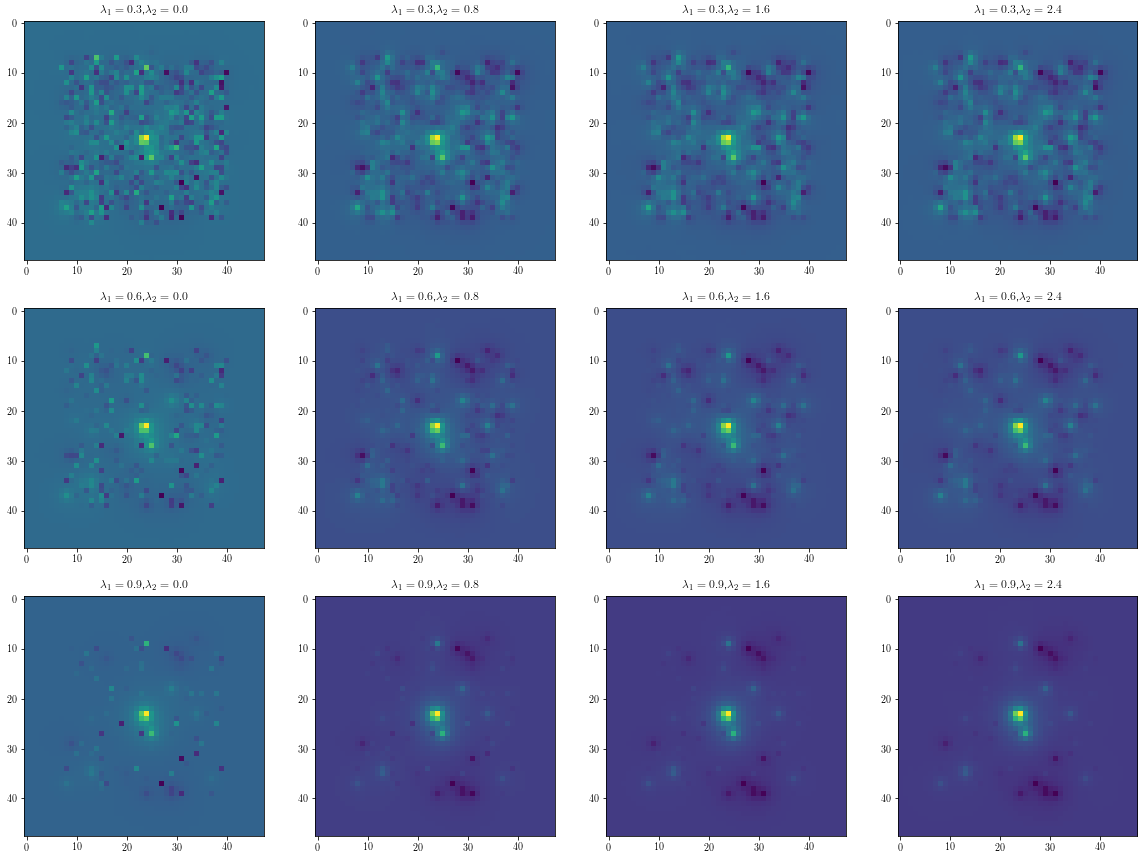

In [93]:
parser.set('sparse','nframe','2')
figure=plt.figure(figsize=(20,15))
for jplot in range(3):
    lbd1=(jplot+1)*0.3
    parser.set('sparse','lbd','%s' %lbd1)
    for iplot in range(4):
        ax=figure.add_subplot(3,4,jplot*4+iplot+1)
        lbd2=iplot*0.8
        parser.set('sparse','lbd2','%s' %lbd2)
        sparse3D    =   massmapSparsityTask(sources,parser)
        sparse3D.process()
        title=r'$\lambda_1=%.1f$,$\lambda_2=%.1f$' %(lbd1,lbd2)
        ax.imshow(sparse3D.deltaR[0,:,:])
        ax.set_title(title)